# Image Clustering with Large Visual Models

- This notebook requires a GPU - make sure to change the runtime type in the "runtime" menu!
- Background reading: https://www.tandfonline.com/doi/full/10.1080/01973762.2024.2362466
- GitHub repository: https://github.com/zentralwerkstatt/pittsburgh

## Setup

Download a toolbox of utility functions (including its dependencies) as well as OpenAI's CLIP model.

In [1]:
%%capture
!rm -rf toolbox # Remove if we have downloaded before
!git clone https://github.com/zentralwerkstatt/toolbox # Clone and install CLIP Github repository
!pip3 install git+https://github.com/openai/CLIP.git
!pip3 install umap-learn filetype # Install some dependencies

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning) # Silence some usual warnings
warnings.filterwarnings("ignore",category=FutureWarning)

Import the libraries we will need:
* `numpy` is a library for matrix operations. It is needed for almost all machine learning applications. We will call it `np` from here on out to save some space.
* `PIL` (pillow) gives us access to easy image manipulation primitives through the `Image` interface.
* `tqdm` gives us a progress bar.
* `KMeans` is an implementation of a centroid-based clustering algorithm that partitions a dataset into similar groups based on the distance between their centroids. It is provided here by the `scikit-learn` library.
* `toolbox` (written by Fabian Offert) contains useful utility functions for digital visual humanities research.



In [4]:
import numpy as np
import PIL.Image
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from datetime import datetime
import pandas as pd
from toolbox import toolbox

## Getting the data



We will work with one of the oldest (for digital art history) datasets around: the Dutch Rijksmuseum's collection. The Rijksmuseum was among the early leaders in "open data". While they have pivoted recently, like many other institutions to an overcomplicated conceptual data model called "CIDOC CRM" (you can immediately forget that) they are still kind enough to provide their original "data dump". Remember: JGTDI! (just gimme the damn images).

In [3]:
# Sample CSV file: Metropolitan Museum data
# You can also upload your own CSV file to the notebook instance, or work with "local" (Google Drive) data as per example below
!wget https://github.com/Rijksmuseum/rijksmuseum.github.io/releases/download/1.0.0/202001-rma-csv-collection.zip
!unzip 202001-rma-csv-collection.zip -d .

--2025-09-12 12:41:47--  https://github.com/Rijksmuseum/rijksmuseum.github.io/releases/download/1.0.0/202001-rma-csv-collection.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/15104650/7525c300-6b8a-11eb-8d0c-1fb21aab7534?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-12T13%3A40%3A42Z&rscd=attachment%3B+filename%3D202001-rma-csv-collection.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-12T12%3A40%3A01Z&ske=2025-09-12T13%3A40%3A42Z&sks=b&skv=2018-11-09&sig=eG1bCQGuQRIcvMoe7rmFoHSvArQCOTWpRNBeOqH7ODg%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1NzY4MTIwNywibmJmIjoxNzU3NjgwOTA3LC

Next, we'll load the Rijksmuseum's comma-separated data into a pandas dataframe.

In [7]:
df = pd.read_csv("202001-rma-csv-collection.csv").dropna() # While loading "drop" all invalid values
selection = df # In case next cell is not run
print(len(df), "data points")
df.head()

374519 data points


objectInventoryNumber                         objectPersistentIdentifier  \
2             AK-BR-324  http://hdl.handle.net/10934/RM0001.COLLECT.321537   
3             AK-BR-325    http://hdl.handle.net/10934/RM0001.COLLECT.3866   
5             AK-BR-972  http://hdl.handle.net/10934/RM0001.COLLECT.328281   
6           AK-BR-BOU-7     http://hdl.handle.net/10934/RM0001.COLLECT.312   
8           AK-BR-FLA-2     http://hdl.handle.net/10934/RM0001.COLLECT.338   

                                      objectTitle[1] objectType[1]  \
2  Klokvormige kom met bleu poudré, draken en parels           kom   
3                Eivormige vaas met een rood glazuur          vaas   
5                        Kom met draken boven golven      spoelkom   
6        Suzuribako met inktsteen en waterdruppelaar    suzuribako   
8        Graffiguur in de vorm van een hurkende dame         beeld   

  objectCreator[1] objectCreationDate[1]  \
2        anonymous                  1800   
3        anonymous                  1800   
5        anonymous                  1700   
6           Suisen                  1700   
8        anonymous                   220   

                                         objectImage  
2  https://lh3.googleusercontent.com/S3wgRasrmmAk...  
3  https://lh3.googleusercontent.com/kc2u8EkKqRbD...  
5  https://lh3.googleusercontent.com/OCREg8JrIikK...  
6  https://lh5.ggpht.com/4aeb-Nu_VC6szPFUV_y-IZLo...  
8  https://lh3.googleusercontent.com/DdiZBimiUqhz...

We know that we have 374519 data points – a bit much for this prototype application to handle (optimization and scaling is what real computer engineers do 90% of the time). So, let's select something interesting from the dataset before we even download any image.



In [31]:
column = "objectCreationDate[1]" #@param {type:"string"}
#@markdown contains (can contain multiple values separated by comma)
value = "1800" #@param {type:"string"}

if "," in value:
    values = [x.strip() for x in value.split(",")]
else:
    values = [value]

selection = []
for value in values:
    selection.append(df.loc[df[column].str.contains(value, case=False)])
selection = pd.concat(selection)

print(len(selection), "data points")
selection

3808 data points


objectInventoryNumber  \
2                  AK-BR-324   
3                  AK-BR-325   
97             AK-KOG-2472-A   
98             AK-KOG-2472-B   
100             AK-KOG-311-A   
...                      ...   
666027              SK-C-179   
666085              SK-C-237   
666086              SK-C-238   
666127              SK-C-283   
666245              SK-C-613   

                               objectPersistentIdentifier  \
2       http://hdl.handle.net/10934/RM0001.COLLECT.321537   
3         http://hdl.handle.net/10934/RM0001.COLLECT.3866   
97        http://hdl.handle.net/10934/RM0001.COLLECT.3867   
98        http://hdl.handle.net/10934/RM0001.COLLECT.3868   
100       http://hdl.handle.net/10934/RM0001.COLLECT.3273   
...                                                   ...   
666027    http://hdl.handle.net/10934/RM0001.COLLECT.9089   
666085   http://hdl.handle.net/10934/RM0001.COLLECT.10672   
666086    http://hdl.handle.net/10934/RM0001.COLLECT.5532   
666127   http://hdl.handle.net/10934/RM0001.COLLECT.10680   
666245    http://hdl.handle.net/10934/RM0001.COLLECT.5531   

                                           objectTitle[1] objectType[1]  \
2       Klokvormige kom met bleu poudré, draken en parels           kom   
3                     Eivormige vaas met een rood glazuur          vaas   
97      Vaas met decoratieve banden en twee leeuwenkop...          vaas   
98      Vaas met decoratieve banden en twee leeuwenkop...          vaas   
100        Peervormige vaas met een gecraqueleerd glazuur          vaas   
...                                                   ...           ...   
666027                                 Lezende oude vrouw    schilderij   
666085                                       De huisvrouw    schilderij   
666086  Landschap met landlieden bij hun vee en hengel...    schilderij   
666127                                          Landschap    schilderij   
666245                             Weidelandschap met vee    schilderij   

               objectCreator[1] objectCreationDate[1]  \
2                     anonymous                  1800   
3                     anonymous                  1800   
97                    anonymous                  1800   
98                    anonymous                  1800   
100                   anonymous                  1800   
...                         ...                   ...   
666027       Meulemans, Adriaan                  1800   
666085   Strij, Abraham van (I)                  1800   
666086         Strij, Jacob van                  1800   
666127  Ducorron, Julien Joseph                  1800   
666245         Strij, Jacob van                  1800   

                                              objectImage  
2       https://lh3.googleusercontent.com/S3wgRasrmmAk...  
3       https://lh3.googleusercontent.com/kc2u8EkKqRbD...  
97      https://lh3.googleusercontent.com/GTfbgBqgBrCk...  
98      https://lh3.googleusercontent.com/0wE1n5fD9OvG...  
100     https://lh3.googleusercontent.com/zKGrpEaTOqT9...  
...                                                   ...  
666027  https://lh5.ggpht.com/gvq2EcbeUJYE0r9zktGrgzpX...  
666085  https://lh4.ggpht.com/Sn9AKhu_7cKv6Il6qPOAOFlK...  
666086  https://lh3.googleusercontent.com/RmT29IPwQgGQ...  
666127  https://lh5.ggpht.com/5ljUiN_zVGb_F3VZVVA5u8nm...  
666245  https://lh3.googleusercontent.com/3Xo8bGVaXXX-...  

[3808 rows x 7 columns]

Very likely you end up with a selection here that's large. Large, for our purposes, is n>250 (but if you continue working at home definitely try some larger numbers!) So, let's just randomly sample our data.

In [32]:
no_samples = 250 #@param {type:"integer"}
sample = selection.sample(n=no_samples)
sample.head()

objectInventoryNumber  \
106537        NG-NM-11218-14   
53734          BK-NM-12235-B   
61789             BK-NM-9211   
640250      RP-T-1993-236(V)   
1904              AK-MAK-714   

                               objectPersistentIdentifier  \
106537  http://hdl.handle.net/10934/RM0001.COLLECT.484503   
53734   http://hdl.handle.net/10934/RM0001.COLLECT.463815   
61789   http://hdl.handle.net/10934/RM0001.COLLECT.375835   
640250  http://hdl.handle.net/10934/RM0001.COLLECT.319355   
1904      http://hdl.handle.net/10934/RM0001.COLLECT.1601   

                                      objectTitle[1]      objectType[1]  \
106537                                          Trom   muziekinstrument   
53734                       Schoen van zwart fluweel            kleding   
61789                      Lap van geborduurde zijde                lap   
640250  Liefdesscène van Krishna en Radha in het bos  Indiase miniatuur   
1904                                            Doos               doos   

       objectCreator[1] objectCreationDate[1]  \
106537        anonymous                  1800   
53734         anonymous                  1800   
61789         anonymous                  1800   
640250        anonymous                  1800   
1904    Gyokuzan, Okada                  1800   

                                              objectImage  
106537  https://lh3.googleusercontent.com/enraEr1fNXBG...  
53734   https://lh3.ggpht.com/8DVrp1n4fZ1PTNnbxgiX7mVK...  
61789   https://lh3.googleusercontent.com/AHxJIDP03Tua...  
640250  https://lh3.googleusercontent.com/XXnDV1t9aBny...  
1904    https://lh3.googleusercontent.com/TUXhqdk6rZ6p...

Let's download all of these! You should probably download them to your Google Drive so there's no need to run all of this again if something fails...

In [33]:
column = "objectImage" #@param {type:"string"}
data_path = "1800" #@param {type:"string"}
toolbox.wgets(sample[column], data_path)
img_paths = toolbox.get_all_files(data_path, ext="jpg")

  0%|          | 0/250 [00:00<?, ?it/s]

Now we are ready to go!

## Clustering images...

First, load our custom (very cool) dataset...

In [34]:
paths = toolbox.get_all_files(data_path, ext="jpg") # Get the paths of all files in the dataset
print(paths[:5]) # Check to see if paths have been loaded

['1800/0000000027.jpg', '1800/0000000024.jpg', '1800/0000000021.jpg', '1800/0000000179.jpg', '1800/0000000088.jpg']


### ... by "brightness"

Extract the features by "flattening" the image - we are simply concatenating all color values into one huge list.

In [35]:

features = np.zeros((len(paths), 32*32*3)) # Make an empty numpy array
for i, path in enumerate(tqdm(paths)): # Move through all the paths
    img = toolbox.load_img(path) # Load the image from disk
    features[i] = toolbox.flatten_img(img, 32) # The second parameter resizes the image

  0%|          | 0/250 [00:00<?, ?it/s]

This gives us 3072-dimensional features, we have to reduce them down to Euclidean space somehow.

In [21]:
print(features.shape) # We check the dimensions of a numpy array with the shape function

(100, 3072)


We will use the [UMAP algorithm](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Uniform_manifold_approximation_and_projection) for this.

In [36]:
reduced_features = toolbox.reduce_features(features) # This uses UMAP by default
print(reduced_features.shape)

(250, 2)


Now let's see how that looks like

In [37]:
img_size = 128 #@param {type:"integer"}
plot = toolbox.plot_imgs_features(paths, img_size, reduced_features) # The second parameter resizes the image

  0%|          | 0/250 [00:00<?, ?it/s]

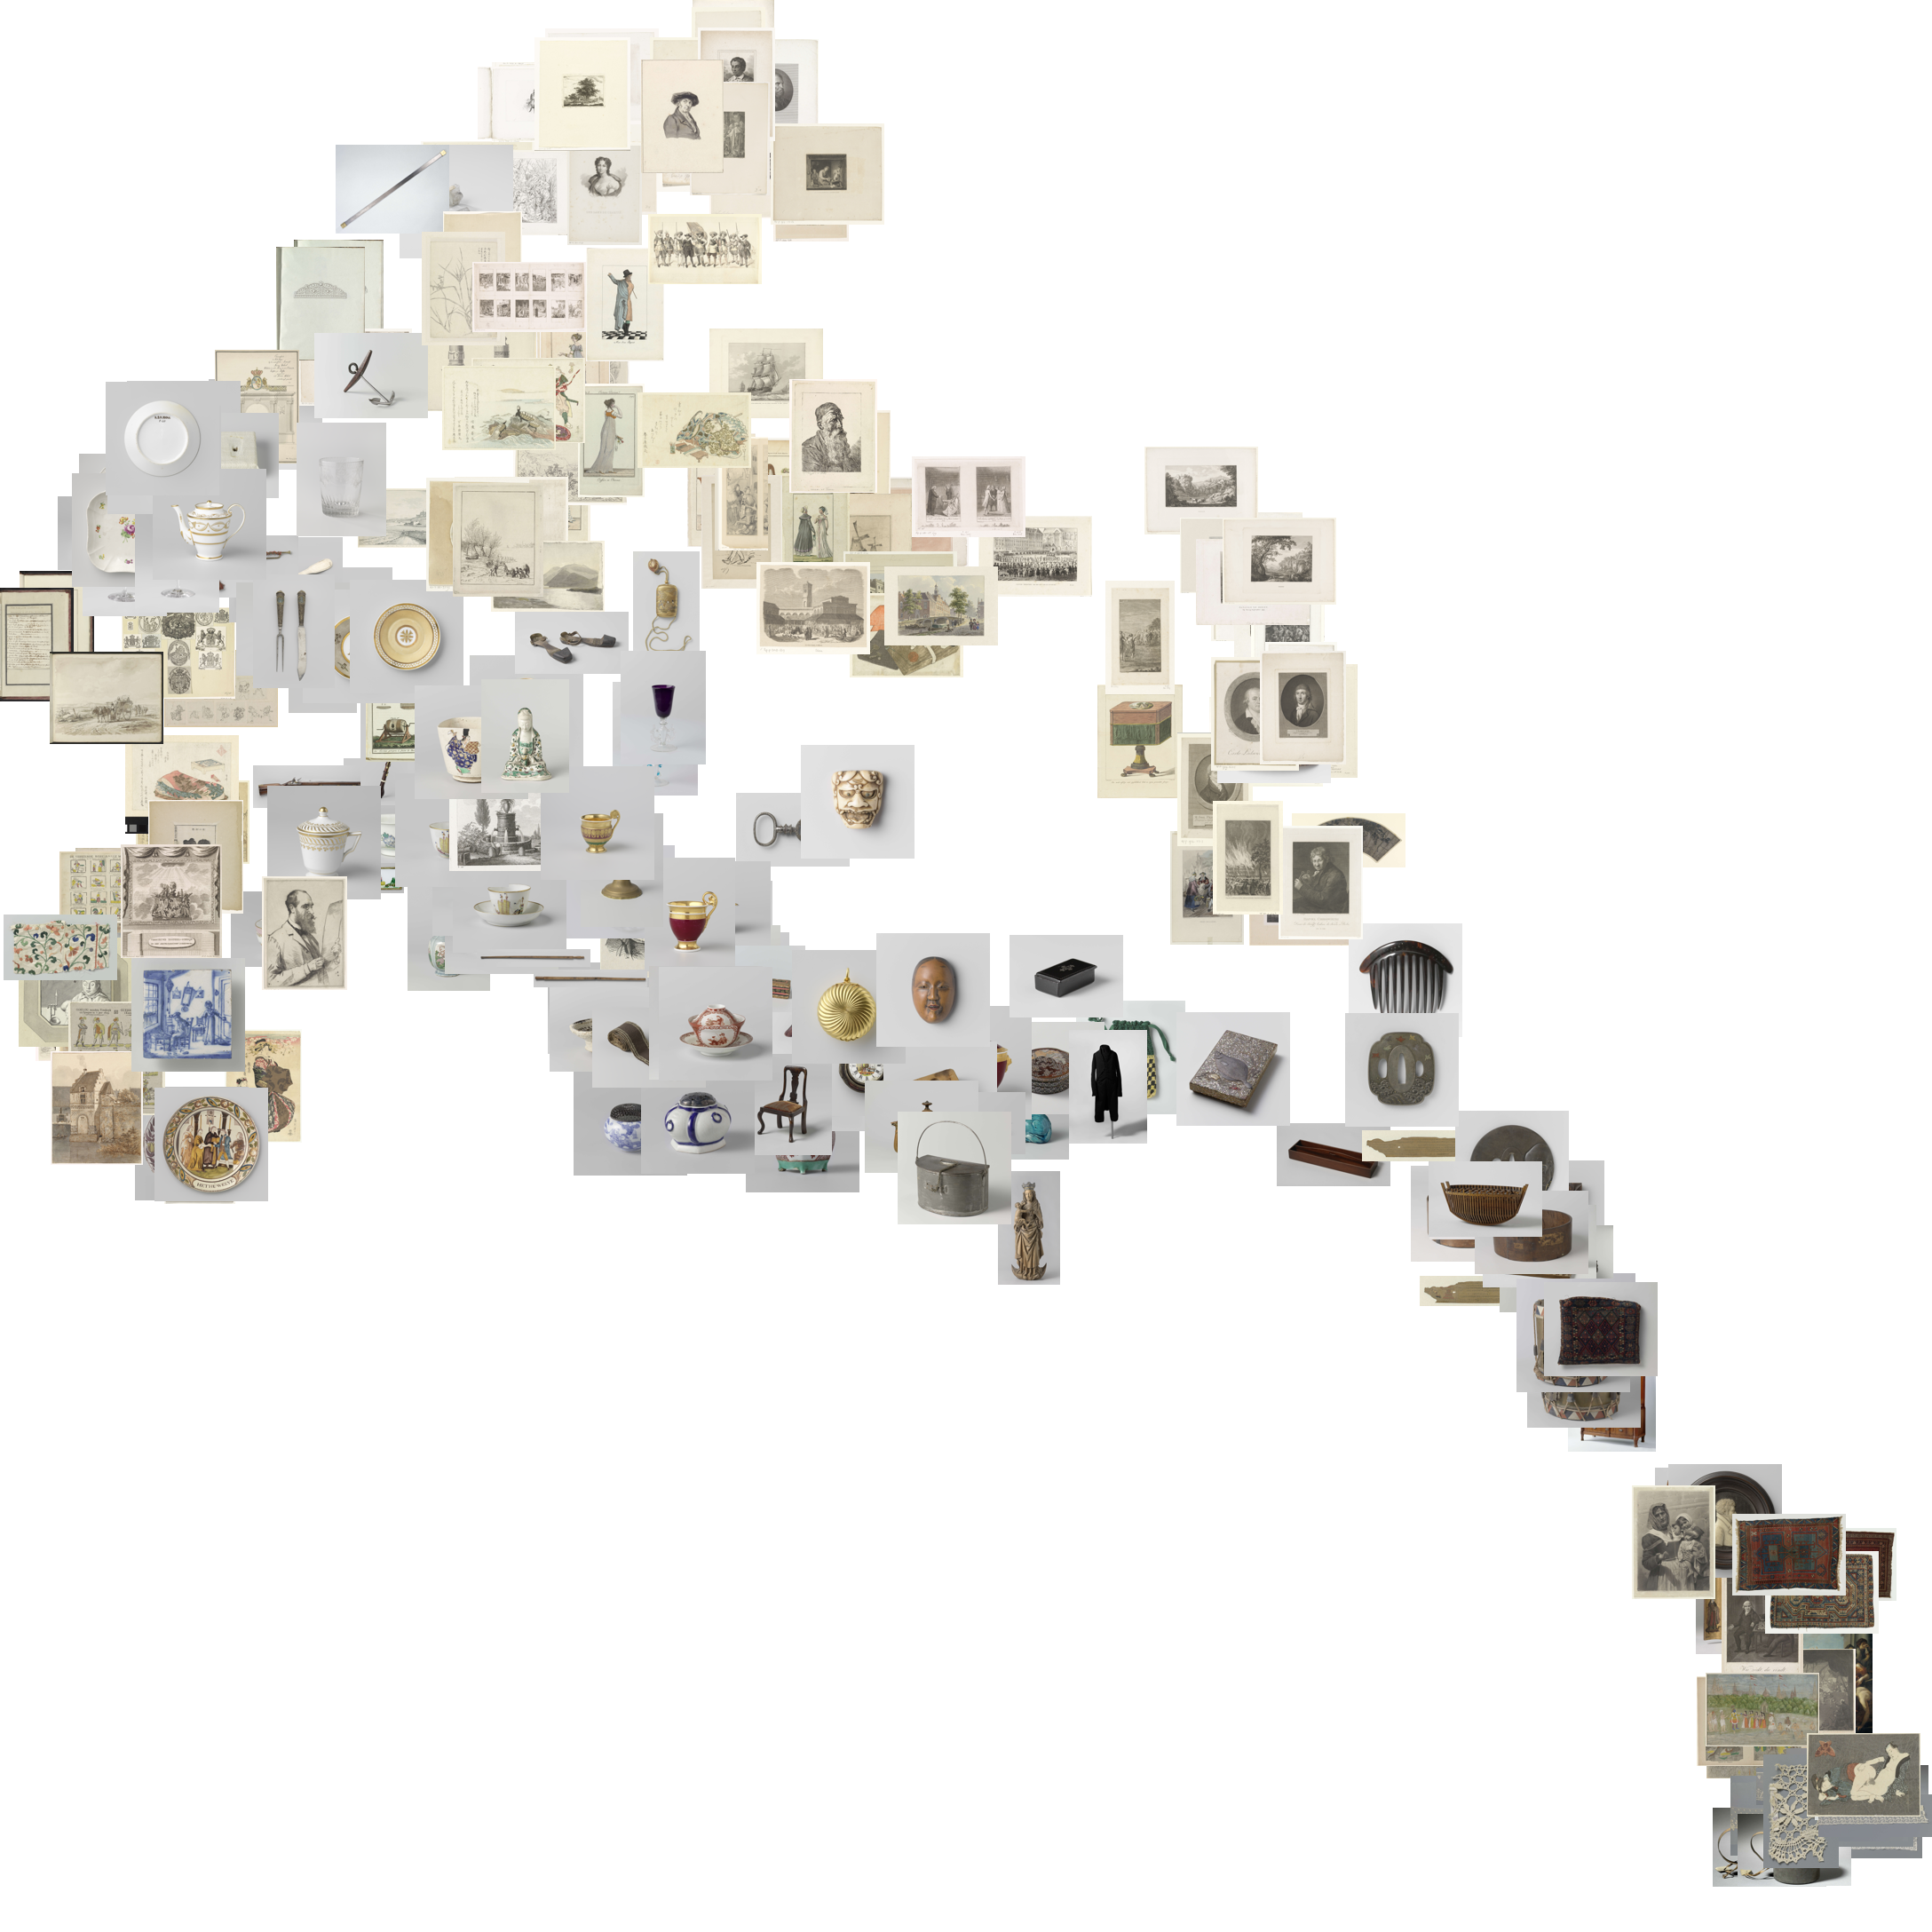

In [38]:
plot

In [12]:
plot.save("plot_raw.jpg")

### ... using CLIP

Usually, however, color will not tell us much about an image dataset. Instead, we can leverage state-of-the-art, fully-trained neural networks, like [CLIP](https://openai.com/blog/clip/), that know something about the *content* of images.

In [39]:
features = np.zeros((len(paths), 512))
for i, path in enumerate(tqdm(paths)):
    img = toolbox.load_img(path)
    features[i] = toolbox.CLIP_img(img)

  0%|          | 0/250 [00:00<?, ?it/s]

In [40]:
print(features.shape)

(250, 512)


CLIP gives us 512-dimensional embeddings, we have to reduce them down to Euclidean space somehow. Again we will use the UMAP algorithm.

In [41]:
reduced_features = toolbox.reduce_features(features)
print(reduced_features.shape)

(250, 2)


In [42]:
img_size = 128 #@param {type:"integer"}
plot = toolbox.plot_imgs_features(paths, img_size, reduced_features)

  0%|          | 0/250 [00:00<?, ?it/s]

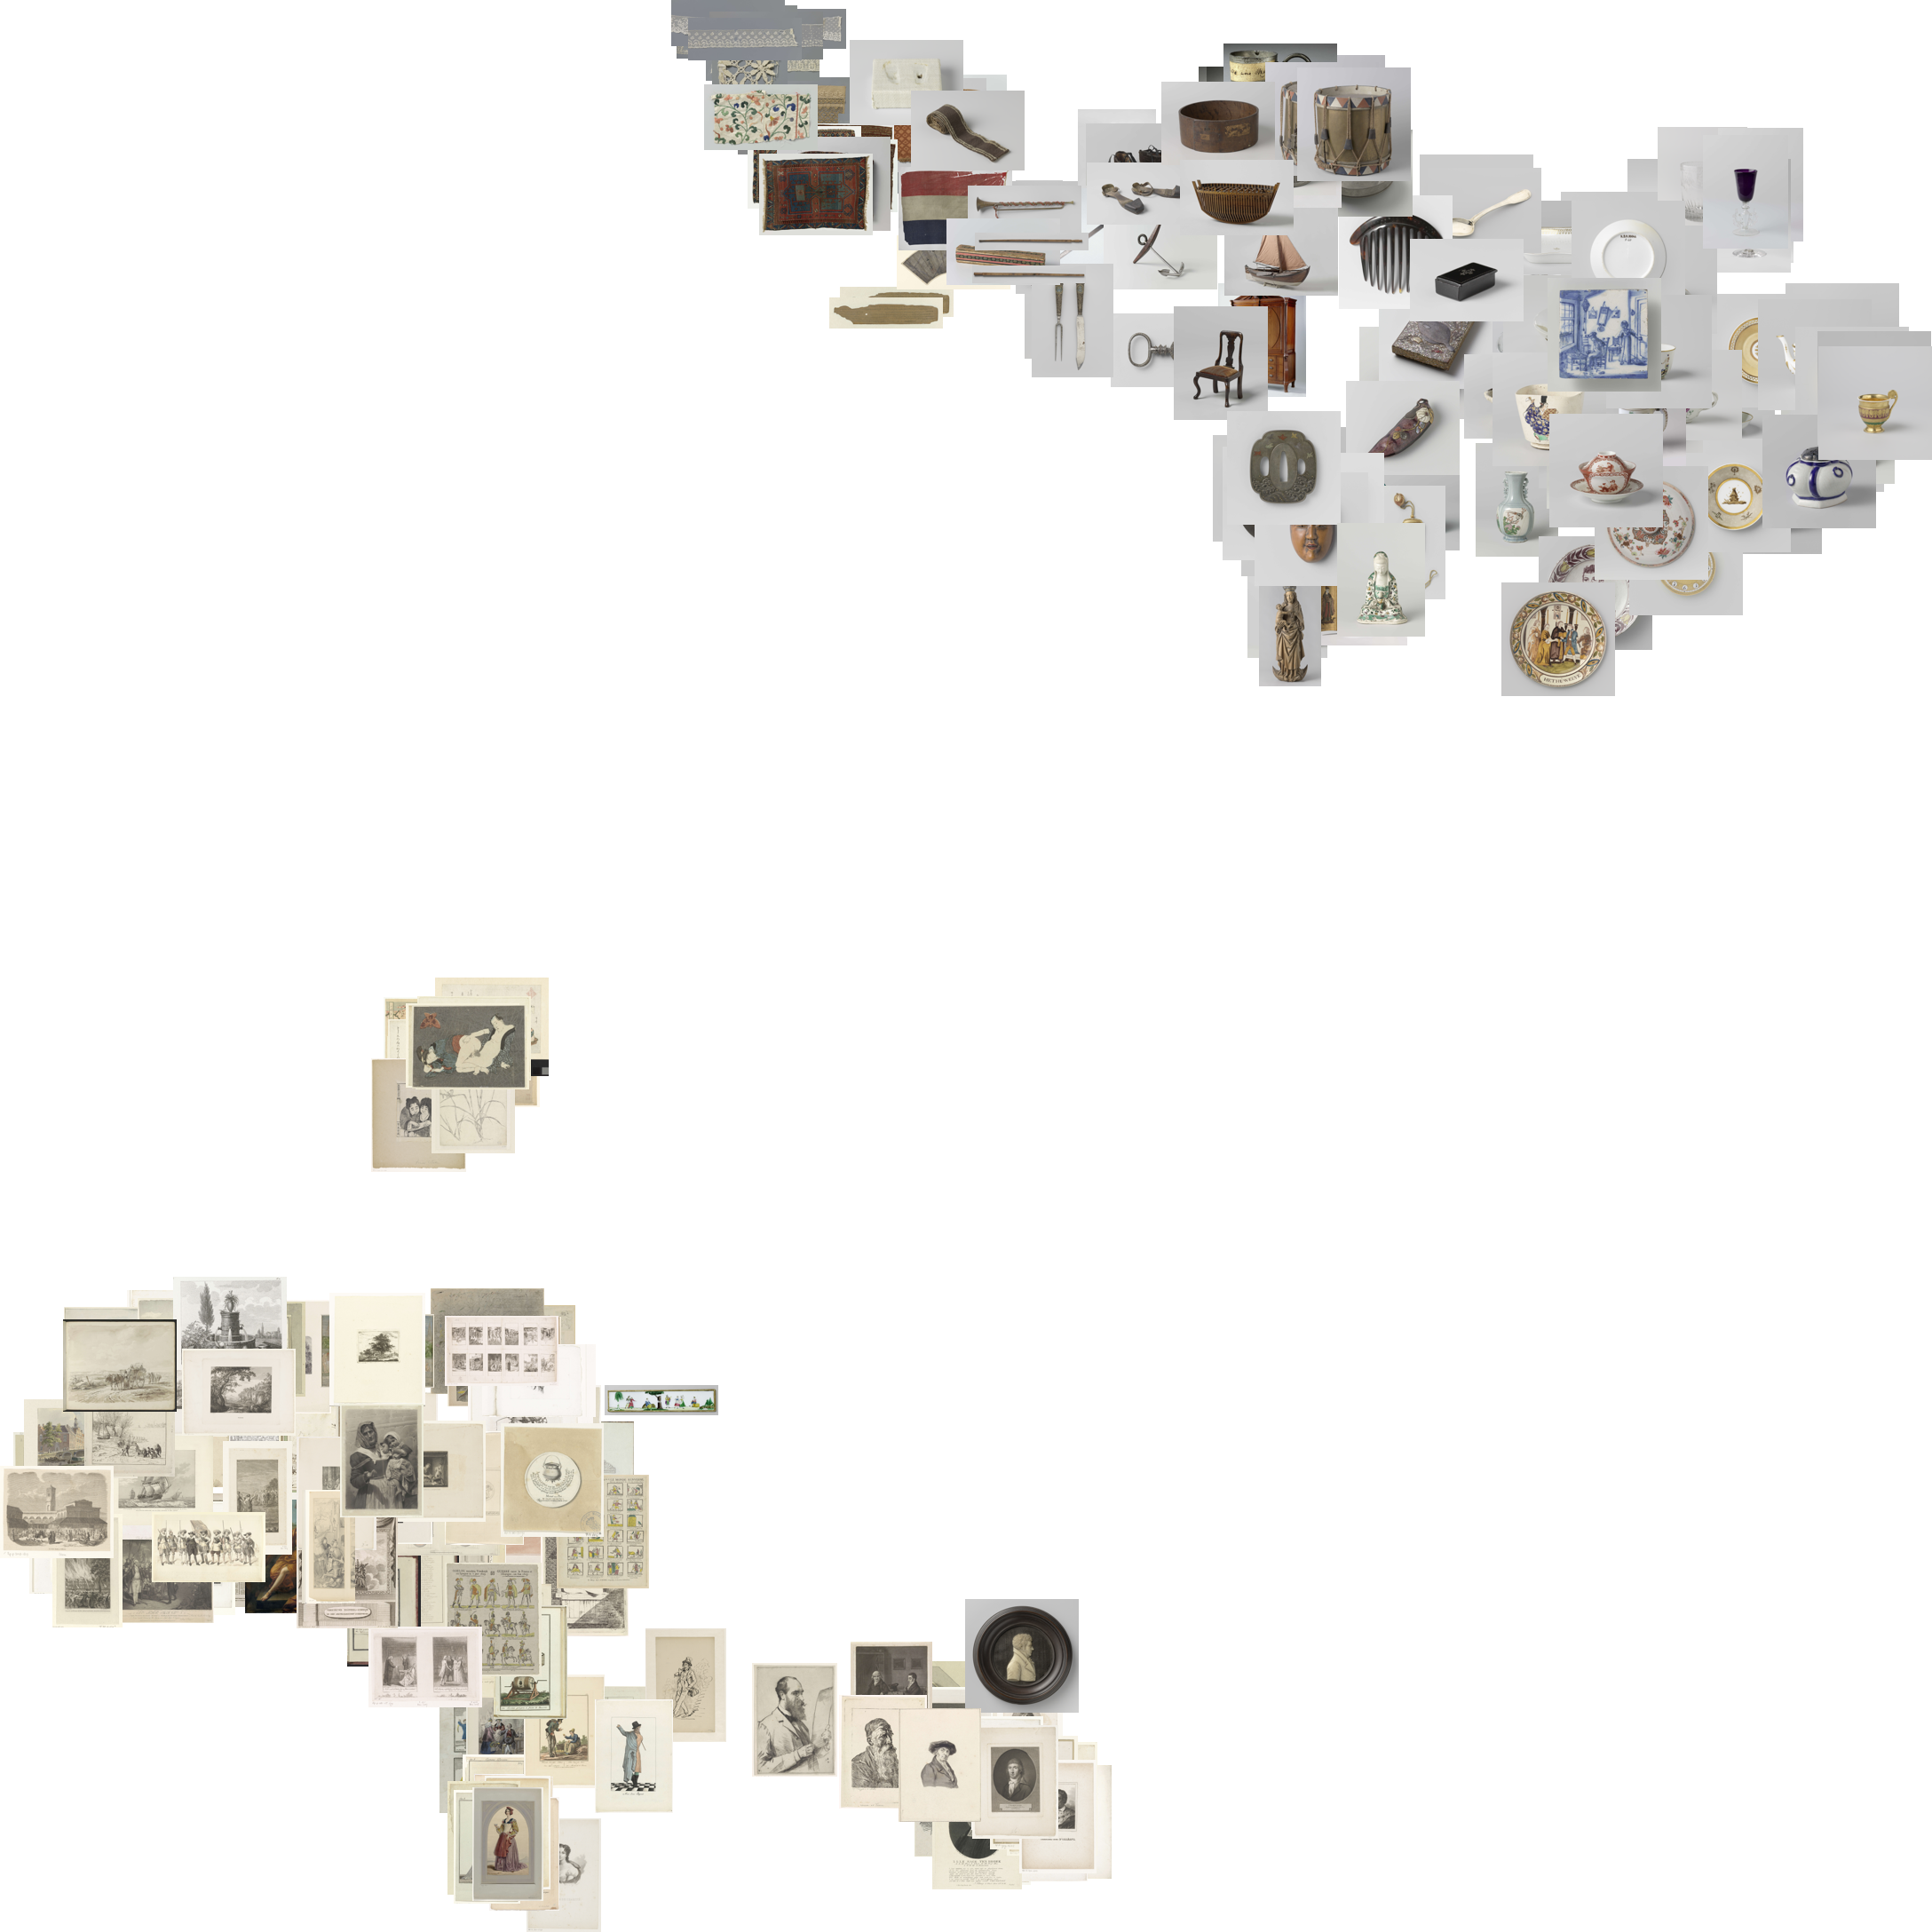

In [43]:
plot

In [18]:
plot.save("plot_clip.jpg")

## Advanced clustering

There are many interesting clusters that we can see in the plot – can we automate this process, too?

In [46]:
n_clusters = 3 #@param {type:"integer"} # KMeans needs us to tell it how many clusters we are looking for!
km = KMeans(n_clusters=n_clusters)
km.fit(features)

KMeans(n_clusters=3)

In [47]:
km.labels_.shape # Each image now has a label that assigns it to a cluster

(250,)

Here is what the algorithm found.

In [48]:
km.labels_[:100]

array([0, 2, 0, 1, 2, 2, 1, 1, 0, 2, 1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2,
       2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2,
       2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1,
       2, 2, 0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2,
       0, 2, 1, 0, 2, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

Let's try to visualize this.

In [49]:
clusters = {}
for c in range(n_clusters): # For each cluster...
    clusters[c] = [] #... make new list.
    for i, path in enumerate(paths): # For each image ...
        if km.labels_[i] == c: # ... if it belongs to the current cluster ...
            clusters[c].append(path) # ... add the path to the list.

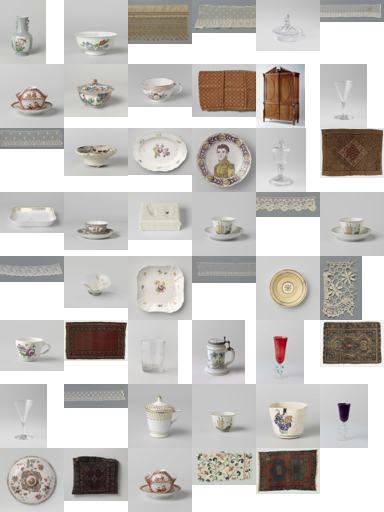

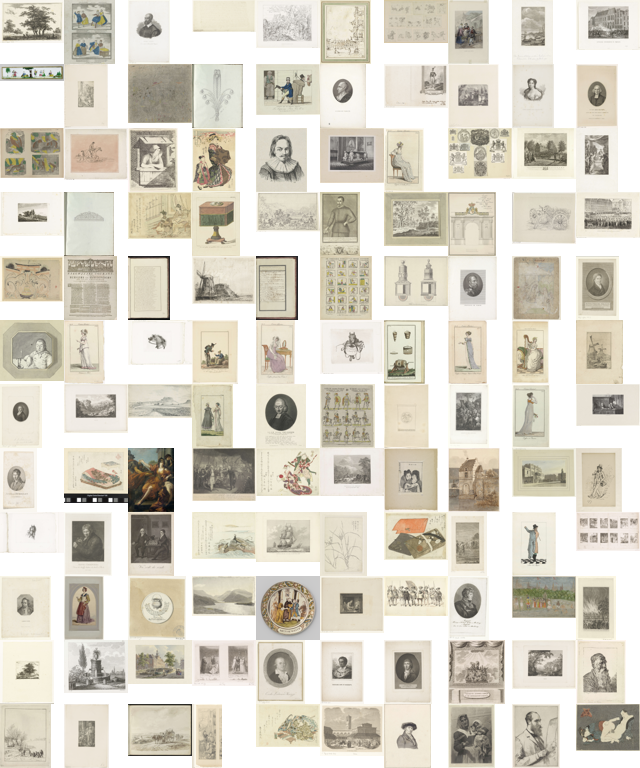

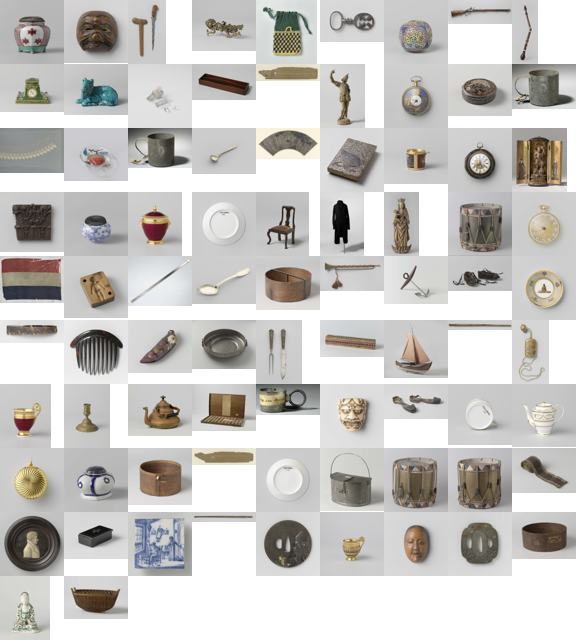

In [52]:
img_size = 64 #@param {type:"integer"}
for c in range(n_clusters): # For each cluster...
    toolbox.show_img(toolbox.plot_imgs_grid(clusters[c], img_size)) # ... plot all associated images as a grid.

No we can visualize where the clusters are in the overview plot.

In [53]:
borders = []
p = toolbox.random_palette(n_clusters) # Create a random palette that has as many colors as we have clusters
for i, path in enumerate(paths):
    borders.append(p[km.labels_[i]]) # Color all images according to their clusters.

In [54]:
img_size = 128 #@param {type:"integer"}
plot = toolbox.plot_imgs_features(paths, img_size, reduced_features, borders)

  0%|          | 0/250 [00:00<?, ?it/s]

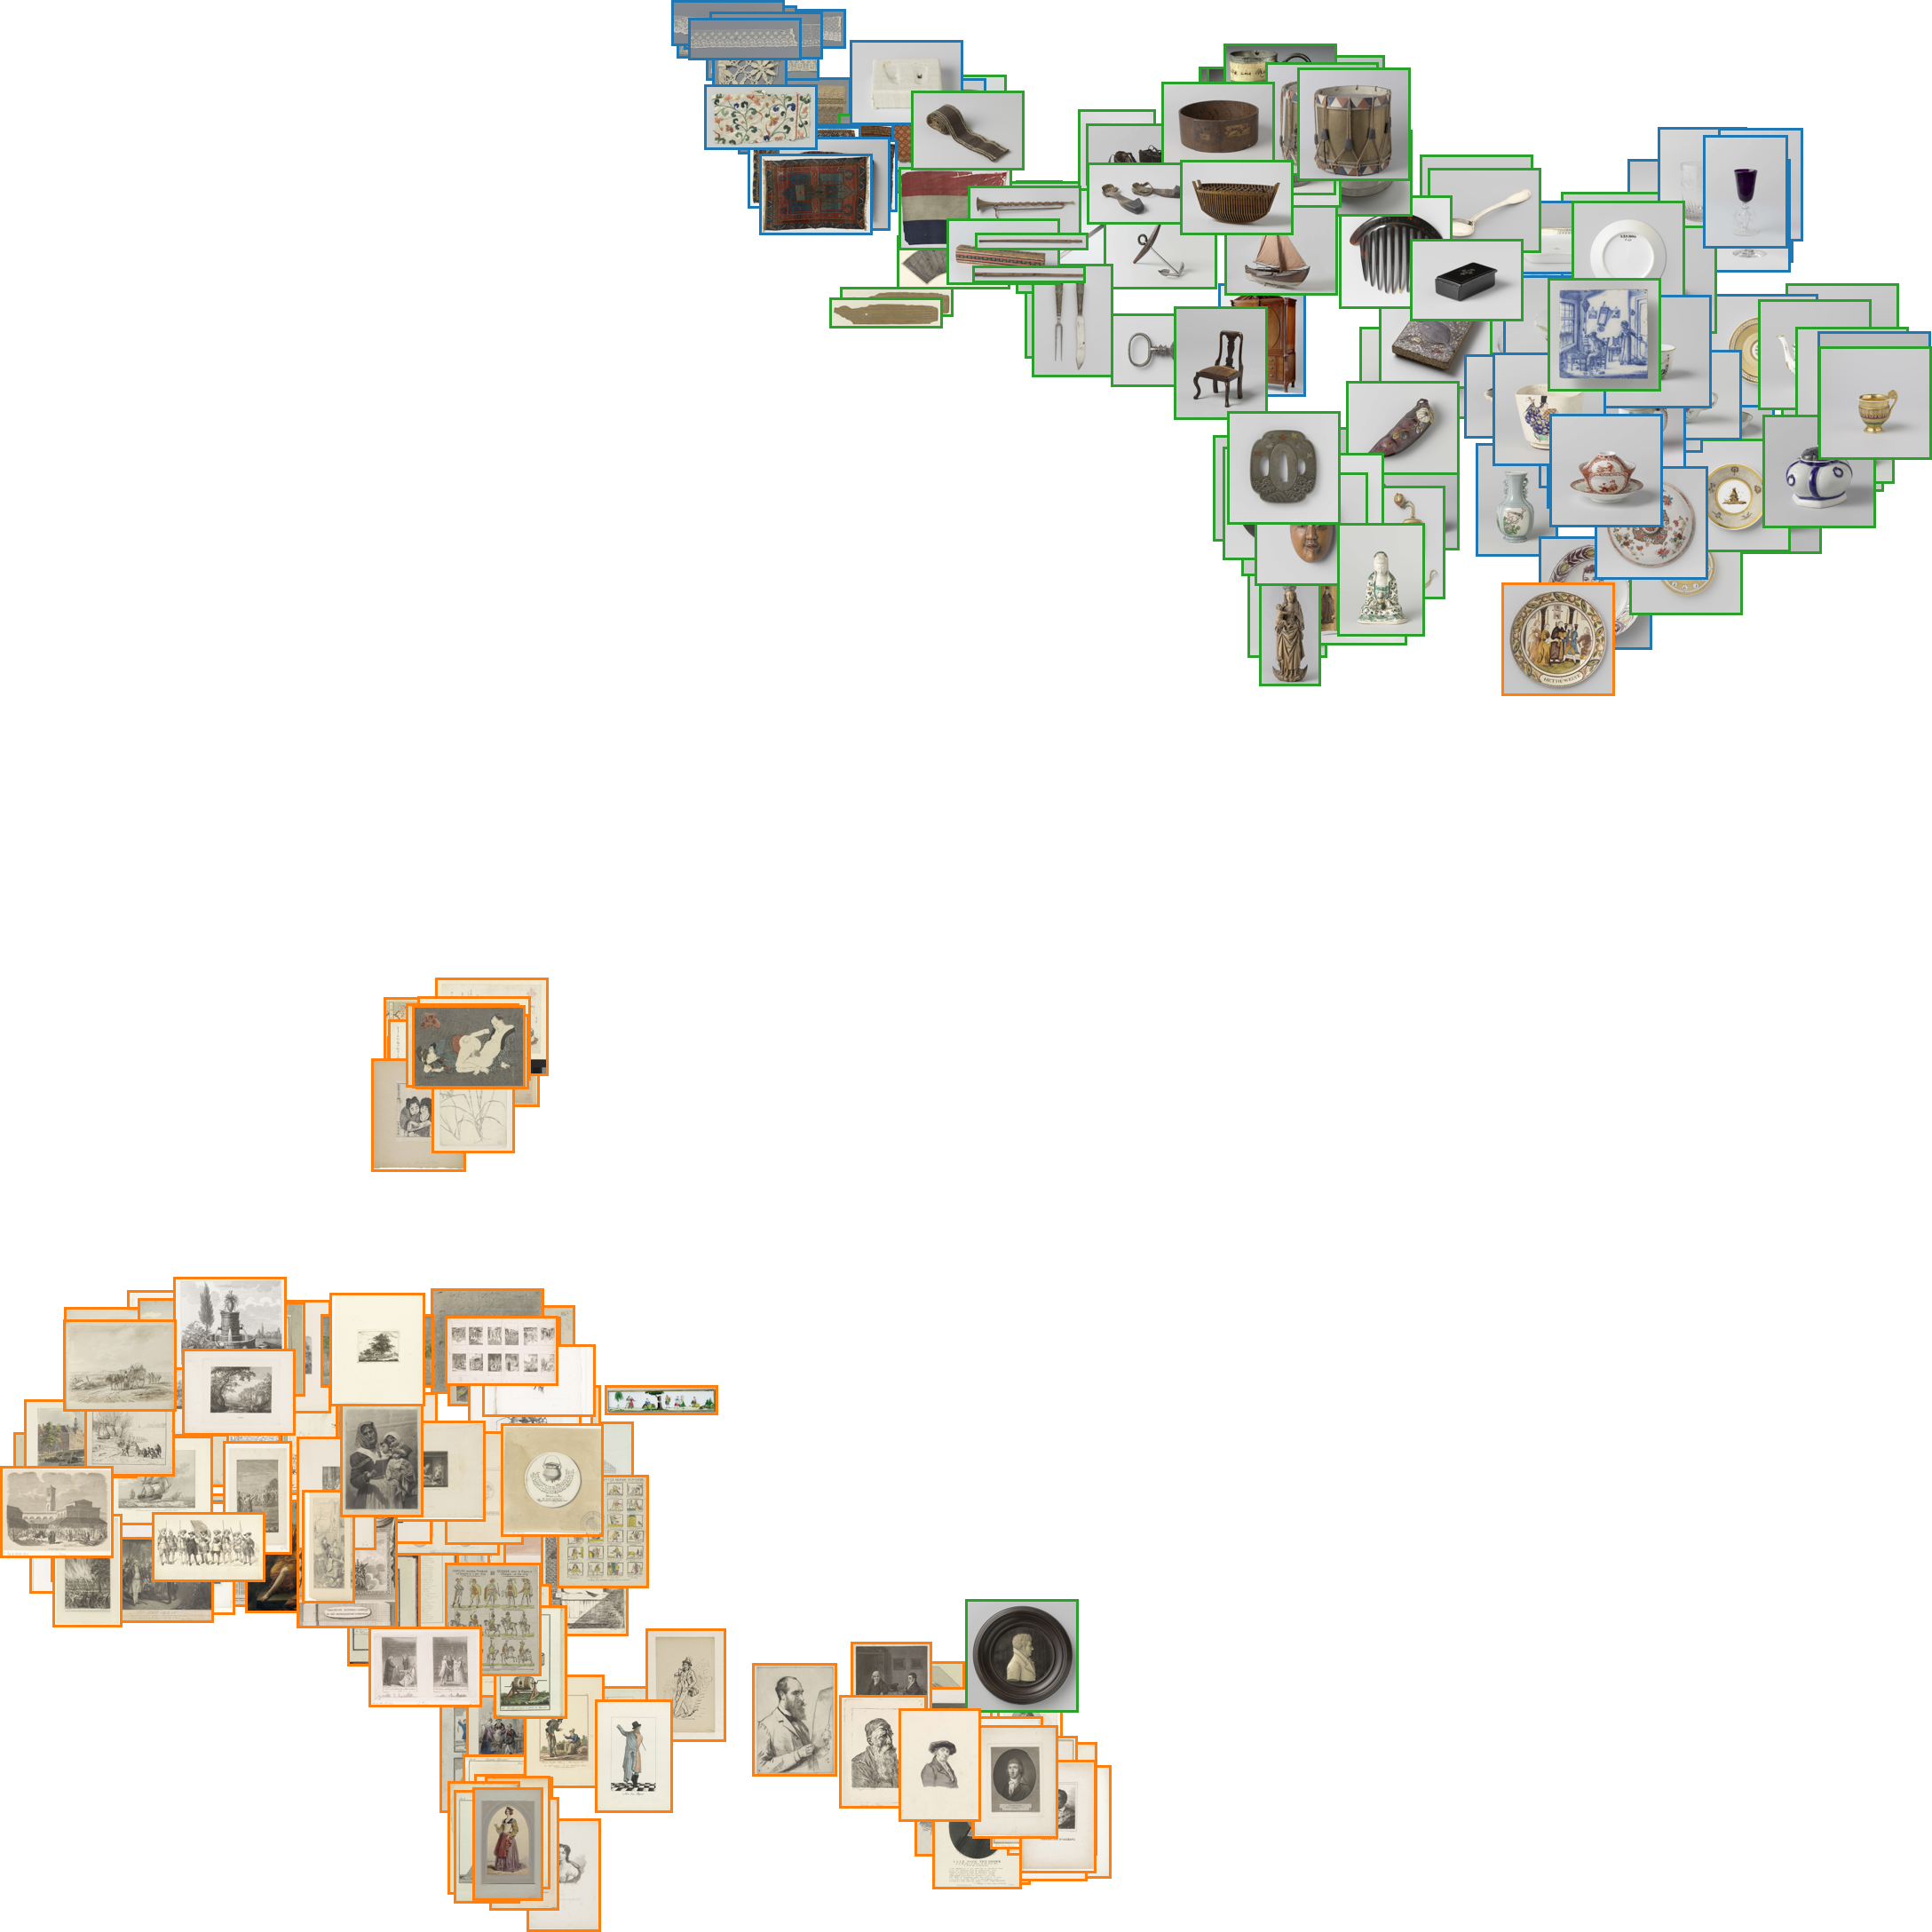

In [56]:
plot

In [28]:
plot.save("plot_clip_borders_clusters.jpg")